In [1]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

from swiper.lattice_surgery_schedule import LatticeSurgerySchedule
from swiper.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule
from swiper.device_manager import DeviceManager
from swiper.window_builder import WindowBuilder
from swiper.window_manager import SlidingWindowManager
from swiper.decoder_manager import DecoderManager
from swiper.simulator import DecodingSimulator
import swiper.plot as plotter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
def draw_dag(G):
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")

    nx.draw_networkx(G, pos=pos)

In [3]:
scheduling_method = 'parallel'

In [4]:
dag = RegularTSchedule(1000, 0).schedule.to_dag(7)

In [5]:
next(nx.topological_generations(dag))

[0, 4]

In [6]:
d=7
decoding_time = 2*d
speculation_time = 200
speculation_accuracy = 0
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

merge_schedule = LatticeSurgerySchedule()
merge_schedule.idle([(0,0)], 10)
merge_schedule.idle([(0,10)], 10)
merge_schedule.merge([(0,0), (0,10)], [(0,i) for i in range(1,10)])

success, device_data, window_data, decoding_data = simulator.run(
    schedule=merge_schedule,
    scheduling_method=scheduling_method,
    max_parallel_processes=None,
    progress_bar=True,
)
print(device_data.num_rounds, decoding_data.num_rounds)

Surface code rounds: 59it [00:00, 22231.96it/s]

17 59


In [7]:
RegularTSchedule(2, 0).schedule.full_instructions()

[Instruction(name='INJECT_T', idx=0, patches=frozenset({(1, 0)}), duration=<Duration.D: 1>, conditioned_on_idx=frozenset(), conditional_dependencies=frozenset(), conditioned_on_completion_idx=frozenset(), conditional_completion_dependencies=frozenset(), merge_faces=frozenset()),
 Instruction(name='MERGE', idx=1, patches=frozenset({(1, 0), (0, 0)}), duration=<Duration.D: 1>, conditioned_on_idx=frozenset(), conditional_dependencies=frozenset({3}), conditioned_on_completion_idx=frozenset(), conditional_completion_dependencies=frozenset(), merge_faces=frozenset({((0, 0), (1, 0))})),
 Instruction(name='DISCARD', idx=2, patches=frozenset({(1, 0)}), duration=0, conditioned_on_idx=frozenset(), conditional_dependencies=frozenset(), conditioned_on_completion_idx=frozenset(), conditional_completion_dependencies=frozenset(), merge_faces=frozenset()),
 Instruction(name='CONDITIONAL_S', idx=3, patches=frozenset({(0, 0)}), duration=<Duration.HALF_D_PLUS_2: 3>, conditioned_on_idx=frozenset({1}), condi

In [8]:
list(RegularTSchedule(2, 0).schedule.to_dag().predecessors(5))

[3, 4]

In [9]:
simulator._device_manager._instruction_durations[3]

0

## RegularTSchedule, not using speculation

Here, speculation time is much longer than decoding time, so we are just doing
standard sliding window.

In [10]:
d=7
decoding_time = 2*d
speculation_time = 100*d
speculation_accuracy = 0

In [11]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [12]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(2,0).schedule,
    scheduling_method=scheduling_method,
    max_parallel_processes=None,
    progress_bar=True,
)

Surface code rounds: 131it [00:00, 26299.72it/s]


In [13]:
decoding_data.num_rounds

131

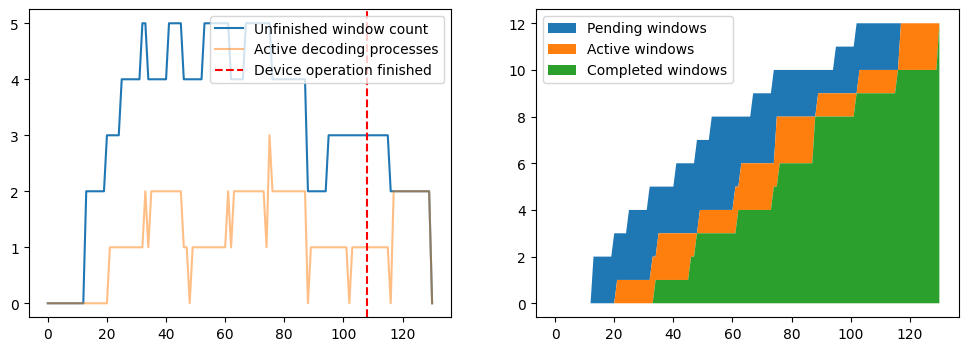

In [14]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

Observe that the number of active decoding processes is far lower, but the rate
of completing windows remains the same.

<Axes3D: >

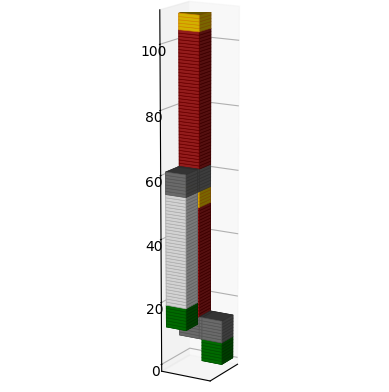

In [15]:
plotter.plot_device_schedule_trace(device_data)

<Axes3D: >

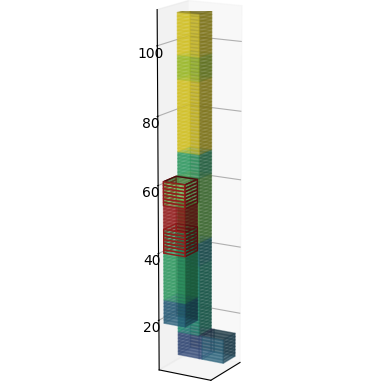

In [16]:
window_completion_times = decoding_data.window_completion_times
plotter.plot_device_schedule_trace(
    device_data,
    windows=window_data.all_windows, 
    window_schedule_times=[window_completion_times[w] for w in window_data.all_windows],
    window_buffers_to_highlight=[7]
)

## 15 - 1 Factory

In [17]:
d=15
decoding_time = 2*d
speculation_time = 100*d
speculation_accuracy = 0

In [18]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [19]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=MSD15To1Schedule().schedule,
    scheduling_method=scheduling_method,
    max_parallel_processes=None,
    progress_bar=True,
)

Surface code rounds: 277it [00:00, 3016.99it/s]


In [20]:
len(simulator._window_manager.all_windows)

141

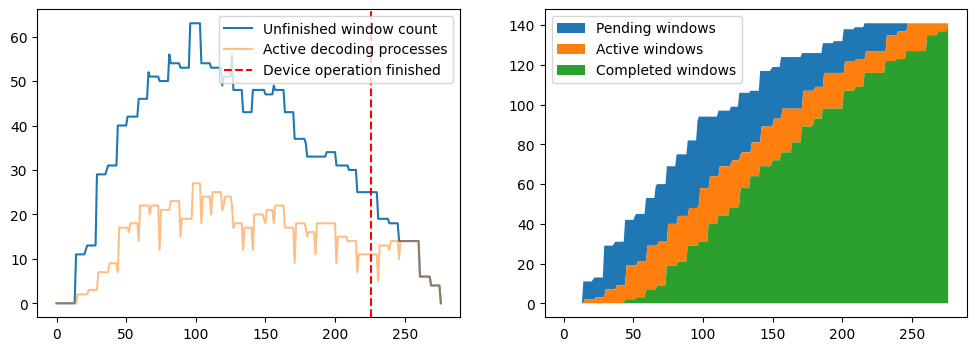

In [21]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

Text(0.5, 0.92, 'parallel (277 rounds)')

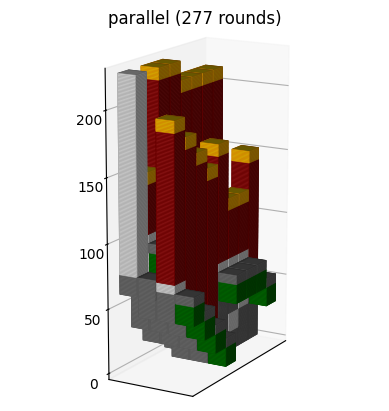

In [22]:
plotter.plot_device_schedule_trace(device_data, spacing=1)
plt.title(f'{scheduling_method} ({decoding_data.num_rounds} rounds)')

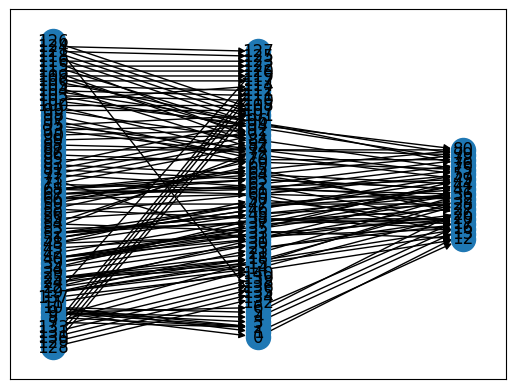

In [23]:
draw_dag(window_data.window_dag)

<Axes3D: >

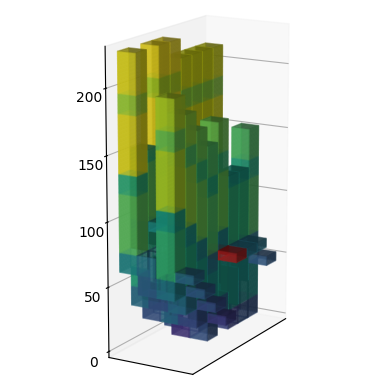

In [24]:
selected_window_idx_1 = -1
for i,window in enumerate(window_data.all_windows):
    if selected_window_idx_1 >= 0:
        break
    for cr in window.commit_region:
        if cr.patch == (3,3):
            selected_window_idx_1 = i
            break

selected_window_idx_2 = -1
for i,window in enumerate(window_data.all_windows):
    if selected_window_idx_2 >= 0:
        break
    for cr in window.commit_region:
        if cr.patch == (2,7) and cr.duration == 3:
            selected_window_idx_2 = i
            break

window_completion_times = decoding_data.window_completion_times
plotter.plot_device_schedule_trace(
    device_data,
    spacing=1,
    windows=window_data.all_windows, 
    window_schedule_times=[window_completion_times[w] for w in window_data.all_windows],
    window_buffers_to_highlight=[selected_window_idx_1, selected_window_idx_2],
)

# Stress test

In [25]:
d=7
decoding_time = 2*d
speculation_time = 2
speculation_accuracy = 0.7

In [26]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [27]:
%%prun
success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(500, 0).schedule,
    scheduling_method=scheduling_method,
    max_parallel_processes=None,
    progress_bar=True,
)
print(device_data.num_rounds, decoding_data.num_rounds)

Surface code rounds: 24362it [00:40, 602.67it/s]


24339 24362
 

         133414743 function calls (132764761 primitive calls) in 41.776 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3382   10.596    0.003   12.057    0.004 digraph.py:489(add_nodes_from)
     3382    6.773    0.002   14.704    0.004 digraph.py:737(add_edges_from)
  5905160    2.819    0.000    3.431    0.000 reportviews.py:799(<genexpr>)
  5905160    2.536    0.000    6.738    0.000 relabel.py:218(<genexpr>)
  5911496    1.867    0.000    4.758    0.000 relabel.py:196(<genexpr>)
 17792305    1.453    0.000    6.211    0.000 {method 'update' of 'dict' objects}
 30130301    1.268    0.000    1.268    0.000 {method 'get' of 'dict' objects}
     3381    1.243    0.000   33.452    0.010 window_manager.py:55(_remove_window)
    24339    1.175    0.000    1.371    0.000 window_builder.py:180(build_windows)
  5915995    1.102    0.000    2.439    0.000 <frozen _collections_abc>:859(__iter__)
  5910116    1.067    0.000   

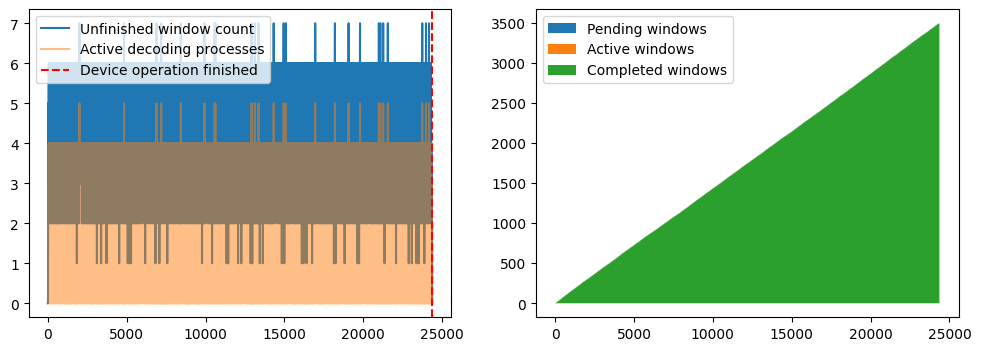

In [28]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

In [30]:
%%prun
success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(100, 0).schedule,
    scheduling_method='parallel',
    max_parallel_processes=None,
    progress_bar=True,
)
print(device_data.num_rounds, decoding_data.num_rounds)

Surface code rounds: 4827it [00:01, 2752.99it/s]


4813 4827
 

         7209699 function calls (7081428 primitive calls) in 1.928 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      658    0.187    0.000    0.470    0.001 digraph.py:737(add_edges_from)
      658    0.151    0.000    0.206    0.000 digraph.py:489(add_nodes_from)
   227774    0.095    0.000    0.236    0.000 relabel.py:218(<genexpr>)
   227774    0.089    0.000    0.112    0.000 reportviews.py:799(<genexpr>)
52048/19002    0.085    0.000    0.136    0.000 device_manager.py:97(_predict_instruction_start_time)
   228998    0.072    0.000    0.177    0.000 relabel.py:196(<genexpr>)
     4813    0.064    0.000    0.100    0.000 window_builder.py:180(build_windows)
   698320    0.056    0.000    0.233    0.000 {method 'update' of 'dict' objects}
  1258383    0.052    0.000    0.052    0.000 {method 'get' of 'dict' objects}
        1    0.048    0.048    1.978    1.978 <string>:1(<module>)
51843/4814    0.047    0.000    0.1

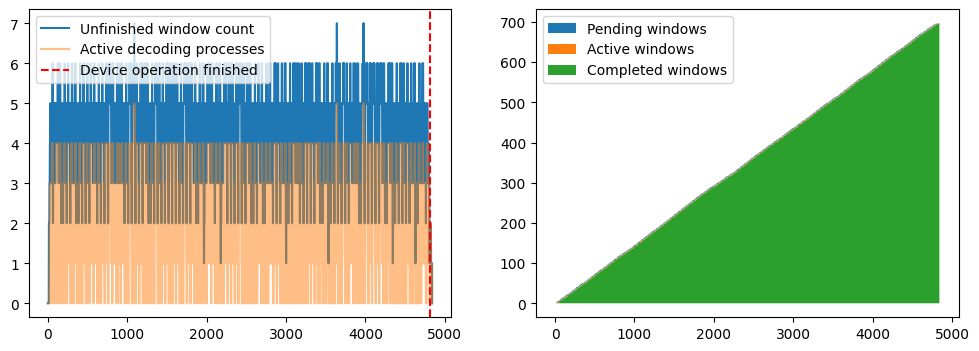

In [31]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()